In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [4]:
# step 1 loading dataset
df=pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# step 2 – Preprocessing & Preparing the Data
#Step 2.1: Encode Labels
from sklearn.preprocessing import LabelEncoder

# Encode the 'dx' column (diagnosis)
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
print("Encoded Labels:", dict(zip(le.classes_, le.transform(le.classes_))))


Encoded Labels: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [6]:
# Step 2.2: Add image paths efficiently using vectorized logic
part1_base = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
part2_base = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Construct potential paths
df["part1_path"] = part1_base + df["image_id"] + ".jpg"
df["part2_path"] = part2_base + df["image_id"] + ".jpg"

# Check which path exists
df["image_path"] = df["part1_path"]
df["image_path"] = df["image_path"].where(df["part1_path"].apply(os.path.exists), df["part2_path"])

# Drop temp columns
df.drop(columns=["part1_path", "part2_path"], inplace=True)

# Drop rows where no image found
df.dropna(subset=["image_path"], inplace=True)

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [7]:
# Step 2.3: Split Dataset
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))


Training samples: 8012
Validation samples: 2003


In [8]:
# 2.4 (A)
# Convert labels to strings for ImageDataGenerator
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 2.4: Define image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.1,    # Randomly shift images horizontally
    height_shift_range=0.1,   # Randomly shift images vertically
    zoom_range=0.2,           # Randomly zoom
    horizontal_flip=True,     # Randomly flip images
    validation_split=0.2      # Split training data into train/val
)


In [10]:
# Step 2.4 (B): Use ImageDataGenerator (with Augmentation)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)



Found 6410 validated image filenames belonging to 7 classes.
Found 1602 validated image filenames belonging to 7 classes.


In [11]:
# Step 3: Build and compile a basic CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Basic CNN architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # HAM10000 has 7 classes
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752498491.420740      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752498491.421423      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6, monitor='val_loss')


In [13]:
# Step 4: Train the model
# Train on full dataset (not just 6 steps)
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=25,  # You can increase this to 20-25 later
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1752498497.500062     118 service.cc:148] XLA service 0x788948007440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752498497.501023     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752498497.501042     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752498497.842858     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/200 ━━━━━━━━━━━━━━━━━━━━ 29:03 9s/step - accuracy: 0.1250 - loss: 1.9188

I0000 00:00:1752498503.157482     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 184s 883ms/step - accuracy: 0.6459 - loss: 1.1987 - val_accuracy: 0.6800 - val_loss: 0.9785
Epoch 2/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7188 - loss: 1.0978

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.7188 - loss: 1.0978 - val_accuracy: 0.6812 - val_loss: 0.9790
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 617ms/step - accuracy: 0.6582 - loss: 1.0207 - val_accuracy: 0.6806 - val_loss: 0.8937
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.7500 - loss: 0.8153 - val_accuracy: 0.6806 - val_loss: 0.8931
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 122s 610ms/step - accuracy: 0.6622 - loss: 0.9700 - val_accuracy: 0.6850 - val_loss: 0.8751
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.5938 - loss: 1.0015 - val_accuracy: 0.6837 - val_loss: 0.8820
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 615ms/step - accuracy: 0.6710 - loss: 0.9331 - val_accuracy: 0.6875 - val_loss: 0.8725
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.7500 - loss: 0.6924 - val_accuracy: 0.6850 - val_loss: 0.8853
Epoch 9/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 122s 612ms/step - accuracy: 0.6732 - loss: 0.8806 -

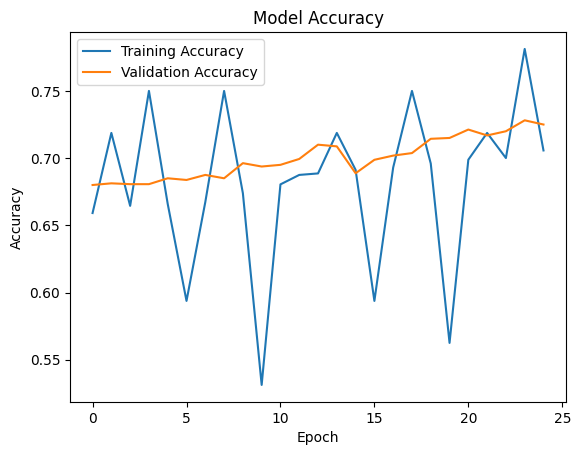

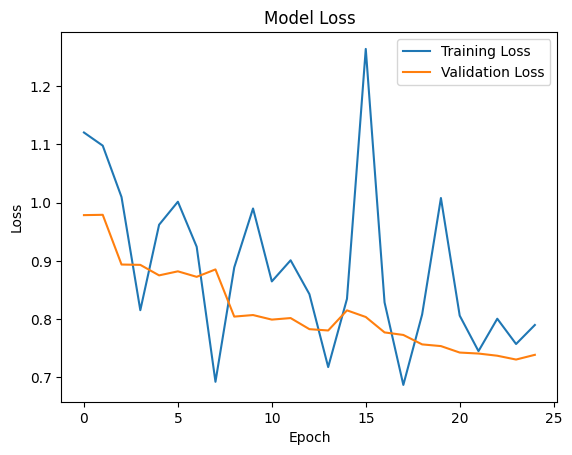

Final Training Accuracy: 0.7057071328163147
Final Validation Accuracy: 0.7250000238418579
Final Training Loss: 0.7899079322814941
Final Validation Loss: 0.7386535406112671


In [14]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final Printed Accuracy and Loss
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])


In [15]:
# MODEL 2 START conclusion
import os, cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Paths
data_dir = "/kaggle/input/skin-cancer-mnist-ham10000"
img_dir1 = os.path.join(data_dir, "HAM10000_images_part_1")
img_dir2 = os.path.join(data_dir, "HAM10000_images_part_2")
metadata_path = os.path.join(data_dir, "HAM10000_metadata.csv")

# Load metadata
df = pd.read_csv(metadata_path)

# Combine both image directories
image_paths = {}
for folder in [img_dir1, img_dir2]:
    for img_file in os.listdir(folder):
        image_paths[img_file] = os.path.join(folder, img_file)

# Prepare images and labels
images = []
labels = []

for index, row in df.iterrows():
    file_name = row['image_id'] + ".jpg"
    label = row['dx']  # diagnosis

    if file_name in image_paths:
        img_path = image_paths[file_name]
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(label)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Output shape confirmation
print("✅ Data loaded successfully:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", le.classes_)


2025-07-15 01:44:14.907958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752543855.309173      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752543855.419576      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Data loaded successfully:
X shape: (10015, 64, 64, 3)
y shape: (10015,)
Unique classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Encode labels as integers
label_encoder = LabelEncoder()
y_encoded_int = label_encoder.fit_transform(y)

# Step 2: One-hot encode the integer labels
y_encoded = to_categorical(y_encoded_int, num_classes=7)


In [4]:
print(label_encoder.classes_)  # ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load ResNet50 without top layer and without pretrained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(7, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


I0000 00:00:1752544029.134205      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752544029.134890      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


NameError: name 'X_val' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


In [ ]:
# Convert label column to string (important for class_mode='sparse')
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load metadata
metadata = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Function to get correct image path from either folder
def find_image_path(image_id):
    part1 = f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{image_id}.jpg"
    part2 = f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/{image_id}.jpg"
    if os.path.exists(part1):
        return part1
    elif os.path.exists(part2):
        return part2
    else:
        return None

# Add valid image paths
metadata['image_path'] = metadata['image_id'].apply(find_image_path)

# Drop rows where image wasn't found
metadata = metadata.dropna(subset=['image_path'])

# Train/val split
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)


In [ ]:
# model 3 MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Use MobileNetV2 without pretrained weights (offline safe)
base_model = MobileNetV2(weights=None, include_top=False, input_tensor=inputs)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint('mobilenet_best_model.h5', save_best_only=True, verbose=1)

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, lr_reduce, checkpoint],
    verbose=1
)


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


In [ ]:
# 📌 Use pretrained weights
base_model = MobileNetV2(weights=None, include_top=False, input_tensor=inputs)


# 📌 Freeze initially
base_model.trainable = False

# 🧠 After 5 epochs, unfreeze top layers:
# for layer in base_model.layers[-30:]:
#     layer.trainable = True

# 📌 Add class weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=train_df['dx']
)
cw = dict(zip(np.unique(train_df['dx']), class_weights))

# 📌 Use in fit:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=cw
)


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


In [ ]:
print(history.history['val_accuracy'])


Epoch 1/10


I0000 00:00:1752544355.190707     102 service.cc:148] XLA service 0x7d4818130160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752544355.192173     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752544355.192196     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752544363.718793     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752544443.980693     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 353s 698ms/step - accuracy: 0.6143 - loss: 1.0946 - val_accuracy: 0.6345 - val_loss: 1.1323
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 290ms/step - accuracy: 0.7180 - loss: 0.7583 - val_accuracy: 0.6885 - val_loss: 0.8542
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/step - accuracy: 0.7343 - loss: 0.7180 - val_accuracy: 0.7284 - val_loss: 0.7521
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7667 - loss: 0.6432 - val_accuracy: 0.7324 - val_loss: 0.7467
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 289ms/step - accuracy: 0.7744 - loss: 0.6118 - val_accuracy: 0.7444 - val_loss: 0.6947
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7787 - loss: 0.5958 - val_accuracy: 0.7399 - val_loss: 0.7292
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7969 - loss: 0.5524 - val_accuracy: 0.7394 - val_loss: 0.7375
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/step - accuracy: 0.8037 - loss: 0.5252 - va

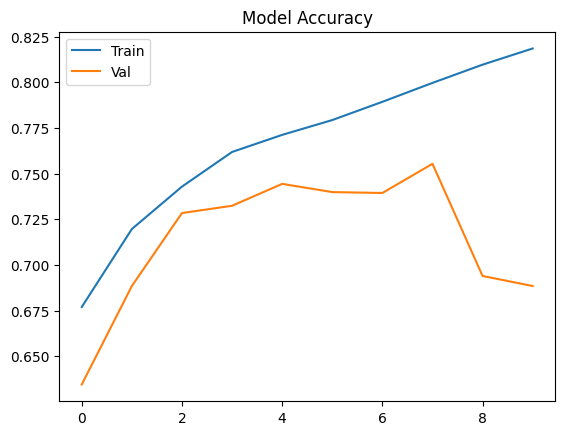

In [7]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# STEP 1: Load CSV
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# STEP 2: Add full image paths from both folders
img_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
img_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

all_img_names = os.listdir(img_dir_1) + os.listdir(img_dir_2)
img_path_dict = {}

for name in os.listdir(img_dir_1):
    img_path_dict[name[:-4]] = os.path.join(img_dir_1, name)

for name in os.listdir(img_dir_2):
    img_path_dict[name[:-4]] = os.path.join(img_dir_2, name)

# STEP 3: Match image_id with image paths
df['image_path'] = df['image_id'].map(img_path_dict)

# STEP 4: Drop NaNs and encode labels
df = df.dropna(subset=['image_path'])
X_paths = df['image_path'].values
y_labels = df['dx'].values

lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

# STEP 5: Load and preprocess images
def load_images(paths, size=(224,224)):
    img_data = []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.resize(img, size)
        img = preprocess_input(img)  # use DenseNet preprocessing
        img_data.append(img)
    return np.array(img_data)

X = load_images(X_paths)

# STEP 6: Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 7: Build DenseNet121 (WITHOUT weights)
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(y.shape[1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# STEP 8: Train model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stop])

# STEP 9: Accuracy Plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.legend()
plt.show()


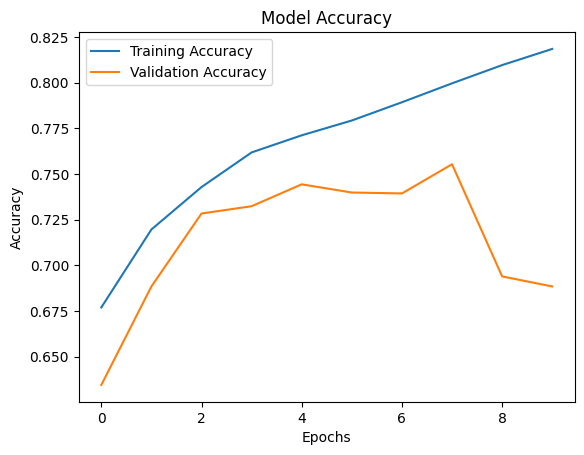

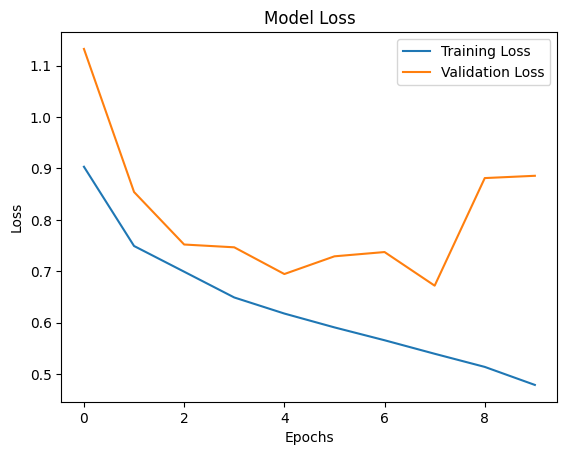

In [8]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.8185
Final Validation Accuracy: 0.6885
Final Training Loss: 0.4792
Final Validation Loss: 0.8857


100%|██████████| 10015/10015 [00:39<00:00, 254.71it/s]


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - accuracy: 0.4236 - loss: 1.8995 - val_accuracy: 0.6900 - val_loss: 1.0498
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.6636 - loss: 1.1851 - val_accuracy: 0.6980 - val_loss: 0.9493
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6754 - loss: 1.0605 - val_accuracy: 0.7000 - val_loss: 0.8957
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.6999 - loss: 0.9631 - val_accuracy: 0.7090 - val_loss: 0.8603
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.6884 - loss: 0.9643 - val_accuracy: 0.7170 - val_loss: 0.8353
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.6867 - loss: 0.9462 - val_accuracy: 0.7200 - val_loss: 0.8196
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6990 - loss: 0.9016 - val_accuracy: 0.7280 - val_loss: 0.8082
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━

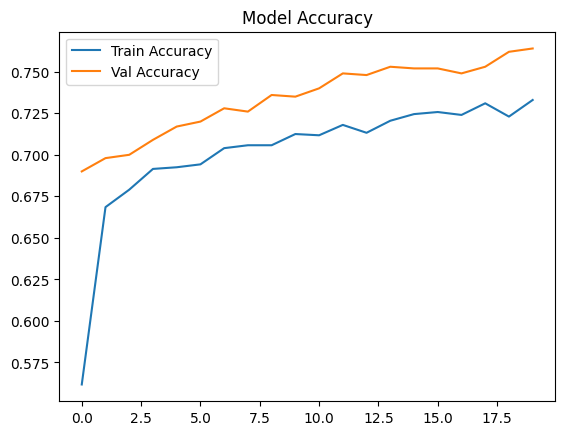

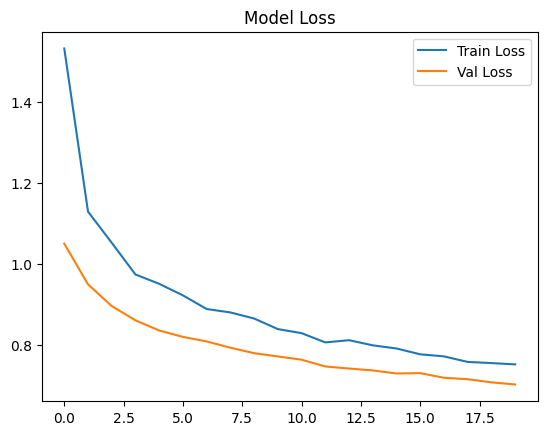


Final Training Accuracy: 0.7645
Final Validation Accuracy: 0.7640
Final Training Loss: 0.6329
Final Validation Loss: 0.7020


In [10]:
# ✅ DenseNet121 - Pretrained Weights (ImageNet)
# 💡 With Explainable AI (Grad-CAM) Support

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tqdm import tqdm

# ✅ Step 1: Load and preprocess data
df = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
df['image_path'] = df['image_id'].apply(lambda x: f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{x}.jpg")

# Map diagnosis labels to numbers
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

# ✅ Step 2: Convert images to array
X = []
y = []

for i in tqdm(range(len(df))):
    path = df['image_path'][i]
    try:
        img = load_img(path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
        y.append(df['label'][i])
    except:
        continue

X = np.array(X)
y = to_categorical(y)

# ✅ Step 3: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ Step 4: Define model with pretrained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Step 5: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# ✅ Step 6: Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.legend()
plt.show()

# ✅ Final Evaluation
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# Step 1: Load CSV and Labels
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df['label'] = pd.Categorical(df['dx']).codes
image_dir = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'

# Step 2: Load & Preprocess Images (Resize + Normalize)
X = []
y = []

for i in tqdm(range(len(df))):
    img_id = df['image_id'][i]
    img_path = os.path.join(image_dir, img_id + '.jpg')
    
    if not os.path.exists(img_path):
        img_path = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', img_id + '.jpg')
    
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)  # Uses ImageNet preprocess
    X.append(img)
    y.append(df['label'][i])

X = np.array(X)
y = to_categorical(y, num_classes=len(np.unique(y)))

# Step 3: Train-Val Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Build Model with Pretrained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

# Step 6: Train the Top Layers
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32, callbacks=[early_stop, reduce_lr])

# Step 7: Unfreeze and Fine-tune the whole model
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning (important to go beyond 85–90%)
history_ft = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stop, reduce_lr])

# Step 8: Final Evaluation
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f"✅ Final Training Accuracy: {train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"✅ Final Training Loss: {train_loss:.4f}")
print(f"✅ Final Validation Loss: {val_loss:.4f}")


2025-07-15 02:52:56.608663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752547976.825531      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752547976.895785      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 10015/10015 [02:29<00:00, 66.93it/s]
I0000 00:00:1752548141.683468      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1752548175.789066      99 service.cc:148] XLA service 0x7e0c48003650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752548175.789763      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752548178.499764      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/251 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.2109 - loss: 2.4262   

I0000 00:00:1752548189.518087      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 209ms/step - accuracy: 0.5443 - loss: 1.5713 - val_accuracy: 0.6755 - val_loss: 0.9917 - learning_rate: 1.0000e-04
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6422 - loss: 1.1825 - val_accuracy: 0.6920 - val_loss: 0.9639 - learning_rate: 1.0000e-04
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6504 - loss: 1.0809 - val_accuracy: 0.6915 - val_loss: 0.9261 - learning_rate: 1.0000e-04
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6705 - loss: 1.0080 - val_accuracy: 0.6935 - val_loss: 0.9213 - learning_rate: 1.0000e-04
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6717 - loss: 0.9810 - val_accuracy: 0.7024 - val_loss: 0.8909 - learning_rate: 1.0000e-04
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6779 - loss: 0.9557 - val_accuracy: 0.7049 - val_loss: 0.8635 - learning_rate: 1.0000e-04
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


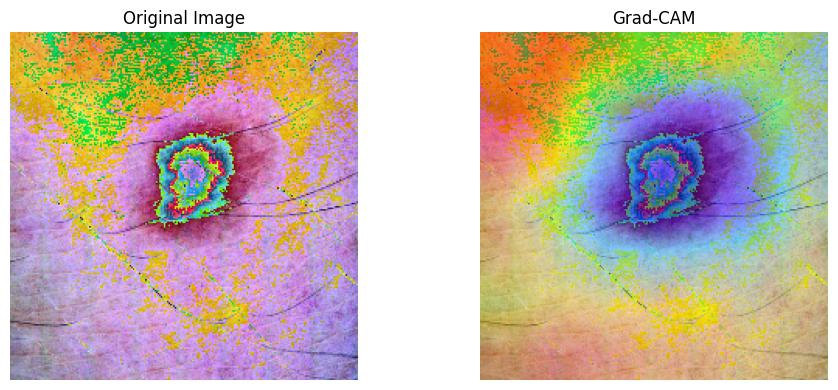

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

# STEP 1: Choose an image from validation set (change index if needed)
img_array = X_val[0]  # Choose any image
img_tensor = np.expand_dims(img_array, axis=0)

# STEP 2: Predict class
preds = model.predict(img_tensor)
pred_class = np.argmax(preds[0])

# STEP 3: Create Grad-CAM model
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

# STEP 4: Compute gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# STEP 5: Normalize heatmap
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# STEP 6: Superimpose on original image
img = (img_array * 255).astype("uint8")
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

# STEP 7: Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')
plt.tight_layout()
plt.show()
